# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Determinación-de-los-parámetros-de-los-polarizadores-lineales" data-toc-modified-id="Determinación-de-los-parámetros-de-los-polarizadores-lineales-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Determinación de los parámetros de los polarizadores lineales</a></div><div class="lev2 toc-item"><a href="#Cargar-la-intensidad-con-P1-y-P4" data-toc-modified-id="Cargar-la-intensidad-con-P1-y-P4-11"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Cargar la intensidad con P1 y P4</a></div><div class="lev2 toc-item"><a href="#Fitting-data-to-sine" data-toc-modified-id="Fitting-data-to-sine-12"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Fitting data to sine</a></div><div class="lev2 toc-item"><a href="#Calibration-parameters" data-toc-modified-id="Calibration-parameters-13"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Calibration parameters</a></div><div class="lev1 toc-item"><a href="#Otros-ajustes" data-toc-modified-id="Otros-ajustes-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Otros ajustes</a></div><div class="lev2 toc-item"><a href="#Fitting-to-matrices---1:-sencillo" data-toc-modified-id="Fitting-to-matrices---1:-sencillo-21"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Fitting to matrices - 1: sencillo</a></div><div class="lev2 toc-item"><a href="#Ajuste-global:-p0,-p1,-angulo" data-toc-modified-id="Ajuste-global:-p0,-p1,-angulo-22"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Ajuste global: p0, p1, angulo</a></div><div class="lev3 toc-item"><a href="#Verificación" data-toc-modified-id="Verificación-221"><span class="toc-item-num">2.2.1&nbsp;&nbsp;</span>Verificación</a></div><div class="lev3 toc-item"><a href="#Comparación" data-toc-modified-id="Comparación-222"><span class="toc-item-num">2.2.2&nbsp;&nbsp;</span>Comparación</a></div><div class="lev3 toc-item"><a href="#Conclusión" data-toc-modified-id="Conclusión-223"><span class="toc-item-num">2.2.3&nbsp;&nbsp;</span>Conclusión</a></div>

# Determinación de los parámetros del divisor de haz usando dos polarizadores

**Autor**: Jesús del Hoyo

**Fecha**:   31/07/2018

**Objetivo**: Ecograb project, polariscope callibration

**Configuración**:

1. Diodo láser de Roithner .... de longitud de onda $\lambda$=850 nm (corriente = 314 mA).
1. Lente colimadora de Thorlabs DG10-600-B.
1. Difusor.
1. Polarizador 1 LPNIRE100-B (P1).
1. Polarizador 4 LPNIRE100-B (P2), solo en Experimento 2.

We assume that beam splitters behaves as a diattenuator retarder with $J_{xy} = J_{yx} = 0$:

\begin{equation}
J_{BS}(0)=\left[\begin{array}{cc}
A & 0  \\
0 & B e^{i\delta}
\end{array}\right]
\end{equation}

**3rd experiment**:
1. Polarizador 1 LPNIRE100-B (P1).
1. Divisor de haz Thorlabs CCM1-BS014/M (BS).
1. Polarizador 1 LPNIRE100-B (P2).

Variables: 
1. 1D, P1 rotation, P2 horizontal.
1. 1D, P1 rotation, P2 vertical.
1. 2D, P1 and P2 rotation.

Parameters that can be extracted from fit:
1. Theta 0 of BS.
1. BS parameters (moddeled as diattenuator retarder).



In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [9]:
from __future__ import print_function

import time
import pprint

from numpy import array, matrix, matmul, power, sum, size, zeros
from math import sin, cos, pi, sqrt
from cmath import exp

from phyton_optics import degrees , sp, plt

from scipy import optimize
from scipy.io import loadmat

from polarimeter.utils import plot_experiment_residuals_1D
from polarimeter.polarimeter import (get_polarimeter_parameters, intensity, 
                                    polarimeter_matrices, get_light_parameters)

from phyton_optics.polarization_jones import rotation
from phyton_optics.polarization_stokes import polarizer_linear, rotate_mueller, polarized_light
from polarimeter.utils import dibujar_2d_fitting


from polarimeter.polarimeter import Intensity_Rotating_Elements
import phyton_optics.polarization_jones as pj
import phyton_optics.polarization_stokes as ps
import numpy as np
import os

## Load data

In [10]:
# Go to the desired folder
#dir = 'calibration'
print(os.getcwd())
#os.chdir(dir)

# Load file, Experiment 3a
filename = 'Experimento_3a_2018-07-31.npz'
data = np.load(filename)
# Rename variables
angle_e3a = data['angle1']*degrees
I_e3a = data['intensity1']
Imax_e3 = data['intensity_max']

# Load file, Experiment 3b
filename = 'Experimento_3b_2018-07-31.npz'
data = np.load(filename)
# Rename variables
angle_e3b = data['angle1']*degrees
I_e3b = data['intensity1']

# Load file, Experiment 3c
filename = 'Experimento_3c_2018-07-31.npz'
data = np.load(filename)
# Rename variables
angle_e3cx = data['angle2x']*degrees
angle_e3cy = data['angle2y']*degrees
I_e3c = data['intensity2']
I_e3c = I_e3c[0:15,0:14] # Wrongy created as a 90x90 zero's matrix


D:\Codigo UCM\polarimeter\notebooks\calibration


## Experiment 3: Rotating both pols

This experiment is done to measure the parameters of the beam splitter. 

Fit parameters for the beam splitter: A = 0.902376642803; B = 0.909639083431; delta = 179.424952458º; Th0 = 175.365740276º;


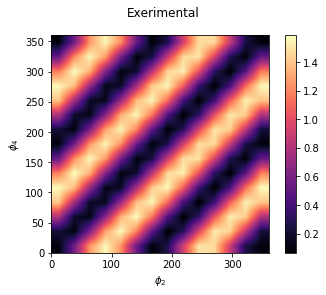

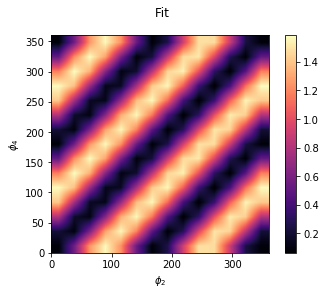

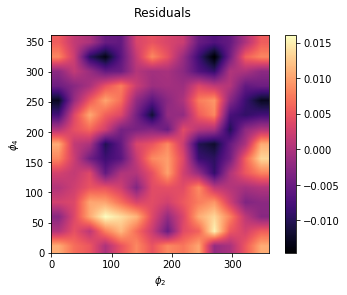

In [12]:
# Initial parameters
Jp = pj.real_polarizer(P1=0.957, P2=0.138)
th0 = [33.98*degrees, 116.87*degrees]
par0 = [.95, 0.95, 0, 0]
# Define calculating and distance functions
def model_func2D(par, th1, th2): 
    Jbs = pj.diattenuator_retarder(delta = par[2], A = par[0], B = par[1])    
    J = [Jp, Jbs, Jp]
    th = [th1-th0[0], par[3], th2-th0[1]]
    I = Intensity_Rotating_Elements(J, th, Imax_e3/2)
    return I
def err_func2D(par, th1, th2, y): 
    dI = model_func2D(par, th1, th2) - y 
    return dI.flatten()
# Optimize
par1, success = optimize.leastsq(err_func2D, par0, args=(angle_e3cx, angle_e3cy, I_e3c))
# Print results
print('Fit parameters for the beam splitter: A = {}; B = {}; delta = {}º; Th0 = {}º;'.format(
        par1[0], par1[1], (par1[2]/degrees)%180, (par1[3]/degrees)%180 ))
#par1[3] = 45*degrees
#par1 = [1, 1, pi/2, pi/4]
I_fitting = model_func2D(par1, angle_e3cx, angle_e3cy)
residuals = I_e3c - I_fitting
dibujar_2d_fitting(angle_e3cx, angle_e3cy, I_e3c, title='Exerimental')
dibujar_2d_fitting(angle_e3cx, angle_e3cy, I_fitting, title='Fit')
dibujar_2d_fitting(angle_e3cx, angle_e3cy, residuals, title='Residuals')


**Check 1: horizontal P2**

To check this result, lets simulate the experiment 3a.

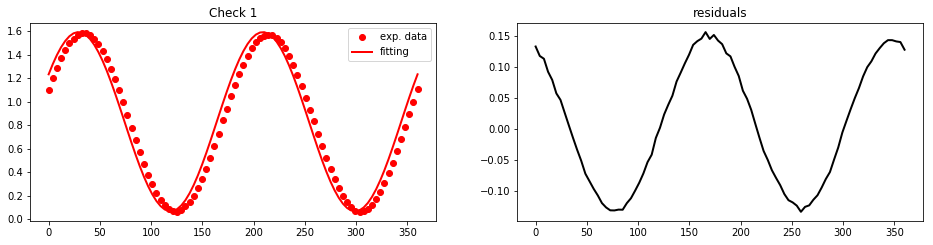

In [41]:
# Initial parameters
Jp = pj.real_polarizer(P1=0.957, P2=0.138)
th0 = [33.98*degrees, 116.87*degrees]
#par = [0.902376642803, 0.909639083431, 179.424952458*degrees, 175.365740276*degrees]
par = [0.902376642803, 0.909639083431, 179.424952458*degrees, -th0[1]+th0[0]]
# Make the experiment
Jbs = pj.diattenuator_retarder(delta = par[2], A = par[0], B = par[1])  
J = [Jp, Jbs, Jp]
th = [angle_e3a-th0[0], -par[3], 0]
I = Intensity_Rotating_Elements(J, th, Imax_e3/2)
# Print result
plot_experiment_residuals_1D(angle_e3a, I_e3a, I,  title='Check 1')

Fit the angle, which seems to be slightly incorrect.

Fit parameters: Th0 = [90.1343759];


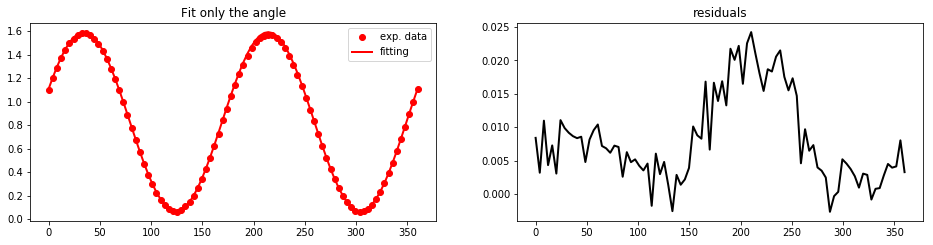

In [44]:
# Initial parameters
Jp = pj.real_polarizer(P1=0.957, P2=0.138)
th0 = [33.98*degrees, 116.87*degrees]
#par = [0.902376642803, 0.909639083431, 179.424952458*degrees, 175.365740276*degrees]
parBS = [0.902376642803, 0.909639083431, 179.424952458*degrees]
Jbs = pj.diattenuator_retarder(delta = parBS[2], A = parBS[0], B = parBS[1])
par0 = -th0[1]+th0[0]
J = [Jp, Jbs, Jp]
# Define calculating and distance functions
def model_func1D(par, th1): 
    th = [angle_e3a-th0[0], par, 0]
    I = Intensity_Rotating_Elements(J, th, Ei = Imax_e3/2)
    return I
def err_func1D(par, th1, y): 
    dI = model_func1D(par, th1) - y 
    return dI
# Check
Dtest = err_func1D(par0, angle_e3a, I_e3a)
# Start optimization
par1, success = optimize.leastsq(err_func1D, par0, args=(angle_e3a, I_e3a))
# Print parameters
print('Fit parameters: Th0 = {};'.format((par1/degrees)%180 ))
# Print results
I_fitting = model_func1D(par1, angle_e3a)
plot_experiment_residuals_1D(angle_e3a, I_e3a, I_fitting,  title='Fit only the angle')

**Check 2: vertical P2**

To check this result, lets simulate the experiment 3b.

In [51]:
# Initial parameters
Jp = pj.real_polarizer(P1=0.957, P2=0.138)
th0 = [33.98*degrees, 116.87*degrees]
#par = [0.902376642803, 0.909639083431, 179.424952458*degrees, 175.365740276*degrees]
parBS = [0.902376642803, 0.909639083431, 179.424952458*degrees]
Jbs = pj.diattenuator_retarder(delta = parBS[2], A = parBS[0], B = parBS[1])
par0 = -th0[1]+th0[0]
J = [Jp, Jbs, Jp]
# Define calculating and distance functions
def model_func1D(par, th1): 
    th = [angle_e3a-th0[0], par, 90*degrees]
    I = Intensity_Rotating_Elements(J, th, Ei = Imax_e3/2)
    return I
def err_func1D(par, th1, y): 
    dI = model_func1D(par, th1) - y 
    return dI
# Check
Dtest = err_func1D(par0, angle_e3b, I_e3b)
# Start optimization
par1, success = optimize.leastsq(err_func1D, par0, args=(angle_e3b, I_e3b))
# Print parameters
print('Fit parameters: Th0 = {};'.format((par1/degrees)%180 ))
# Print results
I_fitting = model_func1D(par1, angle_e3b)
plot_experiment_residuals_1D(angle_e3b, I_e3b, I_fitting,  title='Fit only the angle')

[-1.5697971]


IndexError: index 1 is out of bounds for axis 0 with size 1

## Fit first usin 1D measurements

Thats it, first fit the whole BS using 1D data and check the result using 2D data.

First, horizontal:

Fit parameters for the beam splitter: A = 0.902376642803; B = 0.909639083431; delta = 0.0º; Th0 = 136.607027366º;


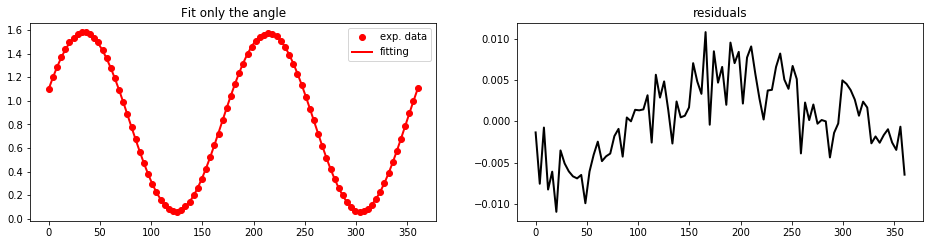

In [61]:
# Initial parameters
Jp = pj.real_polarizer(P1=0.9567, P2=0.138)
th0 = [33.98*degrees, 116.87*degrees]
par0 = [0.902376642803, 0.909639083431, 0*degrees, 90.1*degrees]
# Define calculating and distance functions
def model_func1D(par, th1): 
    Jbs = pj.diattenuator_retarder(delta = par0[2], A = par0[0], B = par0[1])
    J = [Jp, Jbs, Jp]
    th = [angle_e3a-th0[0], par[3], 0]
    I = Intensity_Rotating_Elements(J, th, Ei = Imax_e3/2)
    return I
def err_func1D(par, th1, y): 
    dI = model_func1D(par, th1) - y 
    return dI
# Check
Dtest = err_func1D(par0, angle_e3a, I_e3a)
# Start optimization
par1, success = optimize.leastsq(err_func1D, par0, args=(angle_e3a, I_e3a))
# Print parameters
print('Fit parameters for the beam splitter: A = {}; B = {}; delta = {}º; Th0 = {}º;'.format(
        par1[0], par1[1], (par1[2]/degrees)%180, (par1[3]/degrees)%180 ))
# Print results
I_fitting = model_func1D(par1, angle_e3a)
plot_experiment_residuals_1D(angle_e3a, I_e3a, I_fitting,  title='Fit only the angle')

Obviously, delta is a parameter that cant be fit because P2 is not moving. So I will fit A and B and average them, and fit delta with experiment 3c data.

Now, P2 vertical.

Fit parameters for the beam splitter: A = 0.902376642803; B = 0.909639083431; delta = 0.0º; Th0 = 3.04967750863º;


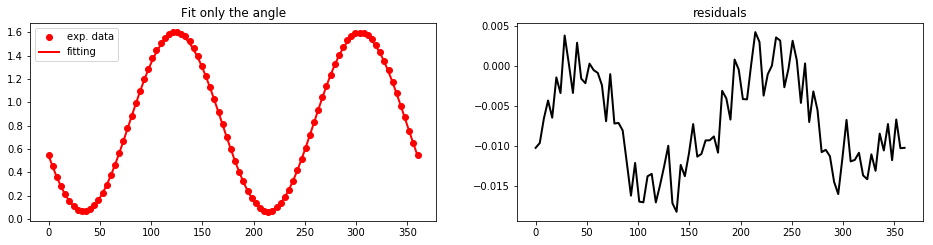

In [62]:
# Initial parameters
Jp = pj.real_polarizer(P1=0.9567, P2=0.138)
th0 = [33.98*degrees, 116.87*degrees]
par0 = [0.902376642803, 0.909639083431, 0*degrees, 90.1*degrees]
# Define calculating and distance functions
def model_func1D(par, th1): 
    Jbs = pj.diattenuator_retarder(delta = par0[2], A = par0[0], B = par0[1])
    J = [Jp, Jbs, Jp]
    th = [angle_e3a-th0[0], par[3], 90*degrees]
    I = Intensity_Rotating_Elements(J, th, Ei = Imax_e3/2)
    return I
def err_func1D(par, th1, y): 
    dI = model_func1D(par, th1) - y 
    return dI
# Start optimization
par1, success = optimize.leastsq(err_func1D, par0, args=(angle_e3b, I_e3b))
# Print parameters
print('Fit parameters for the beam splitter: A = {}; B = {}; delta = {}º; Th0 = {}º;'.format(
        par1[0], par1[1], (par1[2]/degrees)%180, (par1[3]/degrees)%180 ))
# Print results
I_fitting = model_func1D(par1, angle_e3b)
plot_experiment_residuals_1D(angle_e3b, I_e3b, I_fitting,  title='Fit only the angle')

The result for A and B is the same. However, the result for Th0 is inconsistent between them. Also, It is different from the value fitted before for fixed A and B. So I will fit it also using the 2D experiment, and thats it.

Fit parameters for the beam splitter: delta = 0.0º; Th0 = 169.442216196º;


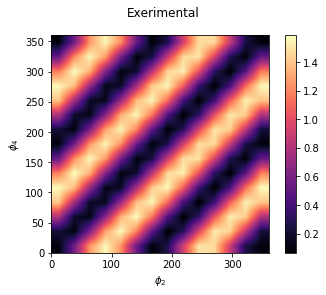

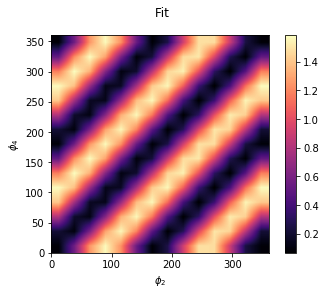

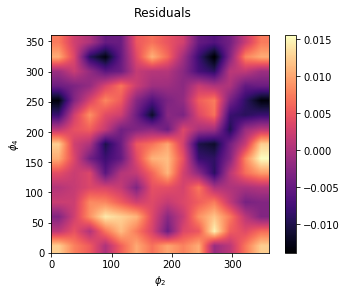

In [60]:
# Initial parameters
Jp = pj.real_polarizer(P1=0.9567, P2=0.138)
th0 = [33.98*degrees, 116.87*degrees]
par0 = [0, 0]
parBS = [0.90237, 0.90964]
# Define calculating and distance functions
def model_func2D(par, th1, th2): 
    #Jbs = pj.diattenuator_retarder(delta = par[0], A = parBS[0], B = parBS[1])    
    Jbs = pj.diattenuator_retarder(delta = 0, A = parBS[0], B = parBS[1])    
    J = [Jp, Jbs, Jp]
    th = [th1-th0[0], par[1], th2-th0[1]]
    I = Intensity_Rotating_Elements(J, th, Imax_e3/2)
    return I
def err_func2D(par, th1, th2, y): 
    dI = model_func2D(par, th1, th2) - y 
    return dI.flatten()
# Optimize
par1, success = optimize.leastsq(err_func2D, par0, args=(angle_e3cx, angle_e3cy, I_e3c))
# Print results
print('Fit parameters for the beam splitter: delta = {}º; Th0 = {}º;'.format(
        (par1[0]/degrees)%180, (par1[1]/degrees)%180 ))
#par1[3] = 45*degrees
#par1 = [1, 1, pi/2, pi/4]
I_fitting = model_func2D(par1, angle_e3cx, angle_e3cy)
residuals = I_e3c - I_fitting
dibujar_2d_fitting(angle_e3cx, angle_e3cy, I_e3c, title='Exerimental')
dibujar_2d_fitting(angle_e3cx, angle_e3cy, I_fitting, title='Fit')
dibujar_2d_fitting(angle_e3cx, angle_e3cy, residuals, title='Residuals')

OK, delta is so close to zero (-0.6º) that I will work using it as zero. $\Theta_0$ varies so much because A and B are very close to each other, so it is very difficult to discriminate. So, in the end, it won´t be an important factor. I will take this one, $169.4º$.

## Conclusion

The beam splitter will be modeled as a "polarizer" with $P_1 = 0.9024$, $P_2 = 0.9096$ and $\Theta_0 = 169.4º$.